In [7]:
pip install yolov5

  Using cached yolov5-7.0.14-py37.py38.py39.py310-none-any.whl.metadata (10 kB)
  Using cached thop-0.1.1.post2209072238-py3-none-any.whl.metadata (2.7 kB)
  Using cached ultralytics-8.3.38-py3-none-any.whl.metadata (35 kB)
  Using cached fire-0.7.0.tar.gz (87 kB)
  Preparing metadata (setup.py) ... done
  Using cached boto3-1.35.71-py3-none-any.whl.metadata (6.7 kB)
  Using cached sahi-0.11.19-py3-none-any.whl.metadata (17 kB)
  Using cached huggingface_hub-0.24.7-py3-none-any.whl.metadata (13 kB)
  Using cached roboflow-1.1.49-py3-none-any.whl.metadata (9.7 kB)
  Using cached botocore-1.35.71-py3-none-any.whl.metadata (5.7 kB)
  Using cached s3transfer-0.10.4-py3-none-any.whl.metadata (1.7 kB)
  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-macosx_11_0_arm64.whl.metadata (20 kB)
  Using cached filetype-1.2.0-py2.py3-none-any.whl.metadata (6.5 kB)
  Using cached opencv_python-4.9.0.80-cp37-abi3-macosx_11_0_arm64.whl.metadata (20 kB)
  Using cached pybboxes-0.1.6-py3-none-any

In [8]:
# Import necessary libraries
import numpy as np
import cv2
import torch
from torchvision import transforms, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from yolov5 import YOLOv5  # Requires YOLOv5 installed
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/Users/omkarthorve/Library/Application Support/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [9]:
def resize_image(image, target_size):
    return cv2.resize(image, target_size)

def normalize_image(image, method='alexnet'):
    if method == 'alexnet':
        return image / 255.0  # Scale to [0,1]
    elif method == 'yolov5':
        return (image / 127.5) - 1.0  # Normalize to [-1, 1]

def augment_image(image):
    datagen = ImageDataGenerator(rotation_range=30,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 zoom_range=0.2,
                                 horizontal_flip=True)
    return datagen.random_transform(image)

def apply_gaussian_blur(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

def hsv_conversion(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

def mean_subtraction(image, mean_values):
    return image - mean_values

def normalize_bounding_boxes(boxes, image_dims):
    h, w = image_dims
    normalized_boxes = boxes.copy()
    normalized_boxes[:, 0] /= w
    normalized_boxes[:, 1] /= h
    normalized_boxes[:, 2] /= w
    normalized_boxes[:, 3] /= h
    return normalized_boxes


In [11]:
# Load dataset (using roboflow dataset path or local directory)
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Mean subtraction
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = '/Users/omkarthorve/Documents/Ganga Flow/Dataset'
image_datasets = {x: ImageFolder(root=f"{data_dir}/{x}", transform=data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=16, shuffle=True)
               for x in ['train', 'val']}


FileNotFoundError: Found no valid file for the classes labels. Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp

In [13]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split


In [14]:
# Root folder for dataset
dataset_path = "/Users/omkarthorve/Documents/Ganga Flow/Dataset"

# Subdirectories
train_images_path = os.path.join(dataset_path, "train/images")
train_labels_path = os.path.join(dataset_path, "train/labels")
valid_images_path = os.path.join(dataset_path, "valid/images")
valid_labels_path = os.path.join(dataset_path, "valid/labels")
test_images_path = os.path.join(dataset_path, "test/images")
test_labels_path = os.path.join(dataset_path, "test/labels")


In [18]:
def load_images_and_labels(image_dir, label_dir, target_size=(224, 224)):
    images = []
    labels = []
    
    for img_name in os.listdir(image_dir):
        # Load image
        img_path = os.path.join(image_dir, img_name)
        img = load_img(img_path, target_size=target_size)
        img = img_to_array(img)
        
        # Load corresponding label
        label_path = os.path.join(label_dir, os.path.splitext(img_name)[0] + ".txt")
        bounding_boxes = []  # Store bounding boxes and class IDs
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as file:
                for line in file.readlines():
                    # Parse YOLO-style label line
                    values = list(map(float, line.strip().split()))
                    class_id = int(values[0])  # First value is the class ID
                    bounding_boxes.append(values)  # Append the full bounding box info

        images.append(img)
        labels.append(bounding_boxes)  # Save bounding box data

    images = np.array(images, dtype="float32")
    return images, labels


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalization and Augmentation
def preprocess_images(images, target_range=(0, 1)):
    # Rescale pixel values
    min_val, max_val = target_range
    images = (images / 255.0) * (max_val - min_val) + min_val
    
    # Augmentation (if needed)
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True
    )
    return images, datagen


In [20]:
# Load training, validation, and test data
train_images, train_labels = load_images_and_labels(train_images_path, train_labels_path)
valid_images, valid_labels = load_images_and_labels(valid_images_path, valid_labels_path)
test_images, test_labels = load_images_and_labels(test_images_path, test_labels_path)

# Preprocess data
train_images, train_datagen = preprocess_images(train_images)
valid_images, _ = preprocess_images(valid_images)
test_images, _ = preprocess_images(test_images)

# Convert labels to categorical if needed (e.g., for classification tasks)
num_classes = len(set(train_labels))
train_labels = to_categorical(train_labels, num_classes)
valid_labels = to_categorical(valid_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)


TypeError: unhashable type: 'list'

In [21]:
# Convert bounding box labels to binary labels (1 for polluted, 0 for not polluted)
def convert_to_binary_labels(labels):
    binary_labels = [1 if len(label) > 0 else 0 for label in labels]
    return binary_labels

# Convert train, validation, and test labels
train_labels = convert_to_binary_labels(train_labels)
valid_labels = convert_to_binary_labels(valid_labels)
test_labels = convert_to_binary_labels(test_labels)

# Determine the number of classes
num_classes = len(set(train_labels))

# Convert labels to categorical for classification
train_labels = to_categorical(train_labels, num_classes)
valid_labels = to_categorical(valid_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)


IndexError: index 1 is out of bounds for axis 1 with size 1

Skipping invalid image file: /Users/omkarthorve/Documents/Ganga Flow/Dataset/valid/.DS_Store
Skipping invalid image file: /Users/omkarthorve/Documents/Ganga Flow/Dataset/valid/images
Skipping invalid image file: /Users/omkarthorve/Documents/Ganga Flow/Dataset/valid/labels
Skipping invalid image file: /Users/omkarthorve/Documents/Ganga Flow/Dataset/test/.DS_Store
Skipping invalid image file: /Users/omkarthorve/Documents/Ganga Flow/Dataset/test/images
Skipping invalid image file: /Users/omkarthorve/Documents/Ganga Flow/Dataset/test/labels
Skipping invalid image file: /Users/omkarthorve/Documents/Ganga Flow/Dataset/train/.DS_Store
Skipping invalid image file: /Users/omkarthorve/Documents/Ganga Flow/Dataset/train/images
Skipping invalid image file: /Users/omkarthorve/Documents/Ganga Flow/Dataset/train/labels


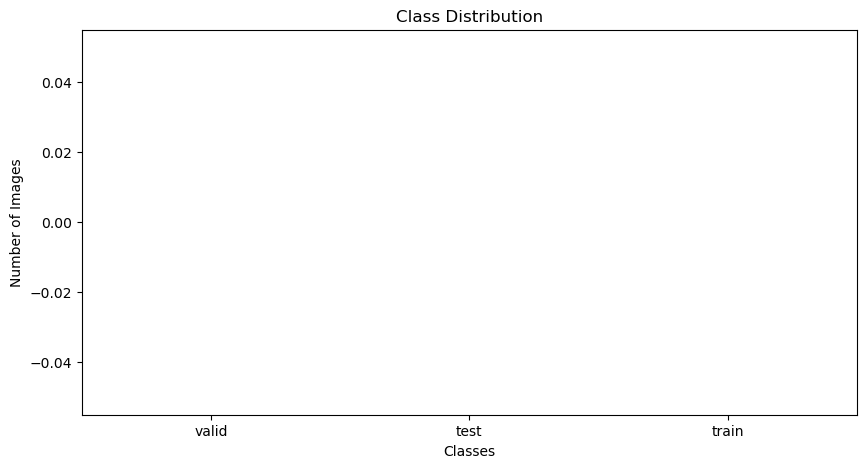

ValueError: not enough values to unpack (expected 2, got 0)

In [1]:
# prompt: I have a Image dataset which has test.train,val folders. write a code to get statistical analysis of that dataset. FYI the image is of ganga river for pollution detection. Also plot data distribution using visualization.

import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

def analyze_image_dataset(dataset_path):
    """
    Analyzes an image dataset and plots data distribution.

    Args:
        dataset_path: Path to the image dataset directory.
    """
    class_counts = {}
    image_sizes = []
    image_formats = {}

    for class_name in os.listdir(dataset_path):
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):
            class_counts[class_name] = 0
            for filename in os.listdir(class_dir):
                image_path = os.path.join(class_dir, filename)
                try:
                    with Image.open(image_path) as img:
                        image_sizes.append(img.size)
                        image_formats[img.format] = image_formats.get(img.format, 0) + 1
                        class_counts[class_name] += 1
                except IOError:
                    print(f"Skipping invalid image file: {image_path}")
    
    # Data Distribution Plots
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.title("Class Distribution")
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.show()


    # Image Size Distribution
    widths, heights = zip(*image_sizes)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=20)
    plt.title("Width Distribution")
    plt.xlabel("Width")
    plt.ylabel("Frequency")

    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=20)
    plt.title("Height Distribution")
    plt.xlabel("Height")
    plt.ylabel("Frequency")
    plt.show()

    # Image Format Distribution
    plt.figure(figsize=(8, 6))
    plt.pie(image_formats.values(), labels=image_formats.keys(), autopct='%1.1f%%')
    plt.title("Image Format Distribution")
    plt.show()

    print("Class Counts:", class_counts)
    print("Image Formats:", image_formats)


# Example usage
dataset_path = "/Users/omkarthorve/Documents/Ganga Flow/Dataset"  # Replace with the actual path
analyze_image_dataset(dataset_path)